## Two-Dimensional Heat Diffusion
#### Heat Equation:
<div style="font-size: 15px">$$\frac{\partial f(x, t)}{\partial t} = \frac{\partial^2f}{\partial x^2} + \frac{\partial^2f}{\partial y^2}$$</div> 

#### Variables:
$$x_i = i \Delta x, \; y_j = j \Delta y, \; t_k = k \Delta t,$$
for $i = 0, \dots, N-1; \; j=0, \dots, N-1; \; and \; k = 0, 1, 2 \dots$

#### Update Equation (Discrete Approximation): 
$$u^{k+1}_{i,j} \approx u^{k}_{i,j} + \epsilon \left( u^{k}_{i+1,j} + u^{k}_{i-1,j} + u^{k}_{i,j+1} + u^{k}_{i,j-1} - 4u^{k}_{i,j} \right)
$$
where $\epsilon$ is a small parameter.

#### Boundary Conditions: 
$$u^k_{-1,j} = u^k_{N,j} \quad u^k_{i,-1} = u^k_{i,N} = 0
$$

In [1]:
N = 101
epsilon = 0.2

### 1. With Matrix Multiplication
As in the linear algebra lecture, let’s use matrix-vector multiplication to simulate the heat diffusion in the 2D space. The vector here is created by `flattening` the current solution . Each iteration of the update is given by:
#### `advance_time_matvecmul`

In [2]:
from heat_equation import advance_time_matvecmul
import inspect
print(inspect.getsource(advance_time_matvecmul))

def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep, via matrix-vector multiplication
    Args:
        A: The 2d finite difference matrix
        u: N x N grid state at timestep k
        epsilon: stability constant

    Returns:
        N x N Grid state at timestep k+1
    """
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u



#### Matrix A: 
Matrix A is a finite difference matrix, which is used in numerical methods to solve partial differential equations like the heat equation on a discrete grid.
 - The main diagonal of A (with entries of -4) corresponds to the current point on the temperature grid, accounting for the four neighbors each point has in the grid (in a non-boundary position).
 
 - The diagonals immediately above and below the main diagonal (with entries of 1) represent the left and right neighbors in the grid, respectively.
 
  - The diagonals N steps away from the main diagonal (also with entries of 1) represent the top and bottom neighbors in the grid.
  

In [5]:
n = N * N
diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-N), np.ones(n-N)]
diagonals[1][(N-1)::N] = 0
diagonals[2][(N-1)::N] = 0
A = np.diag(diagonals[0]) + np.diag(diagonals[1], 1) + np.diag(diagonals[2], -1) + np.diag(diagonals[3], N) + np.diag(diagonals[4], -N)
A

array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]])

#### `get_A`

In [6]:
from heat_equation import get_A
print(inspect.getsource(get_A))

def get_A(N): 
    """
    Generates the matrix A used in the finite difference scheme of the 2D heat equation.
    
    Args:
        N (int): The dimension of the square grid.
        
    Returns:
        np.ndarray: A square matrix of size N^2 x N^2 representing the discretized Laplacian operator with Dirichlet boundary conditions.
    """
    # Total number of points
    n = N * N
    diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-N), np.ones(n-N)]
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0
    A = np.diag(diagonals[0]) + np.diag(diagonals[1], 1) + np.diag(diagonals[2], -1) + np.diag(diagonals[3], N) + np.diag(diagonals[4], -N)
    return A 



Total computation time for 2700 iterations: 71.08664393424988 seconds


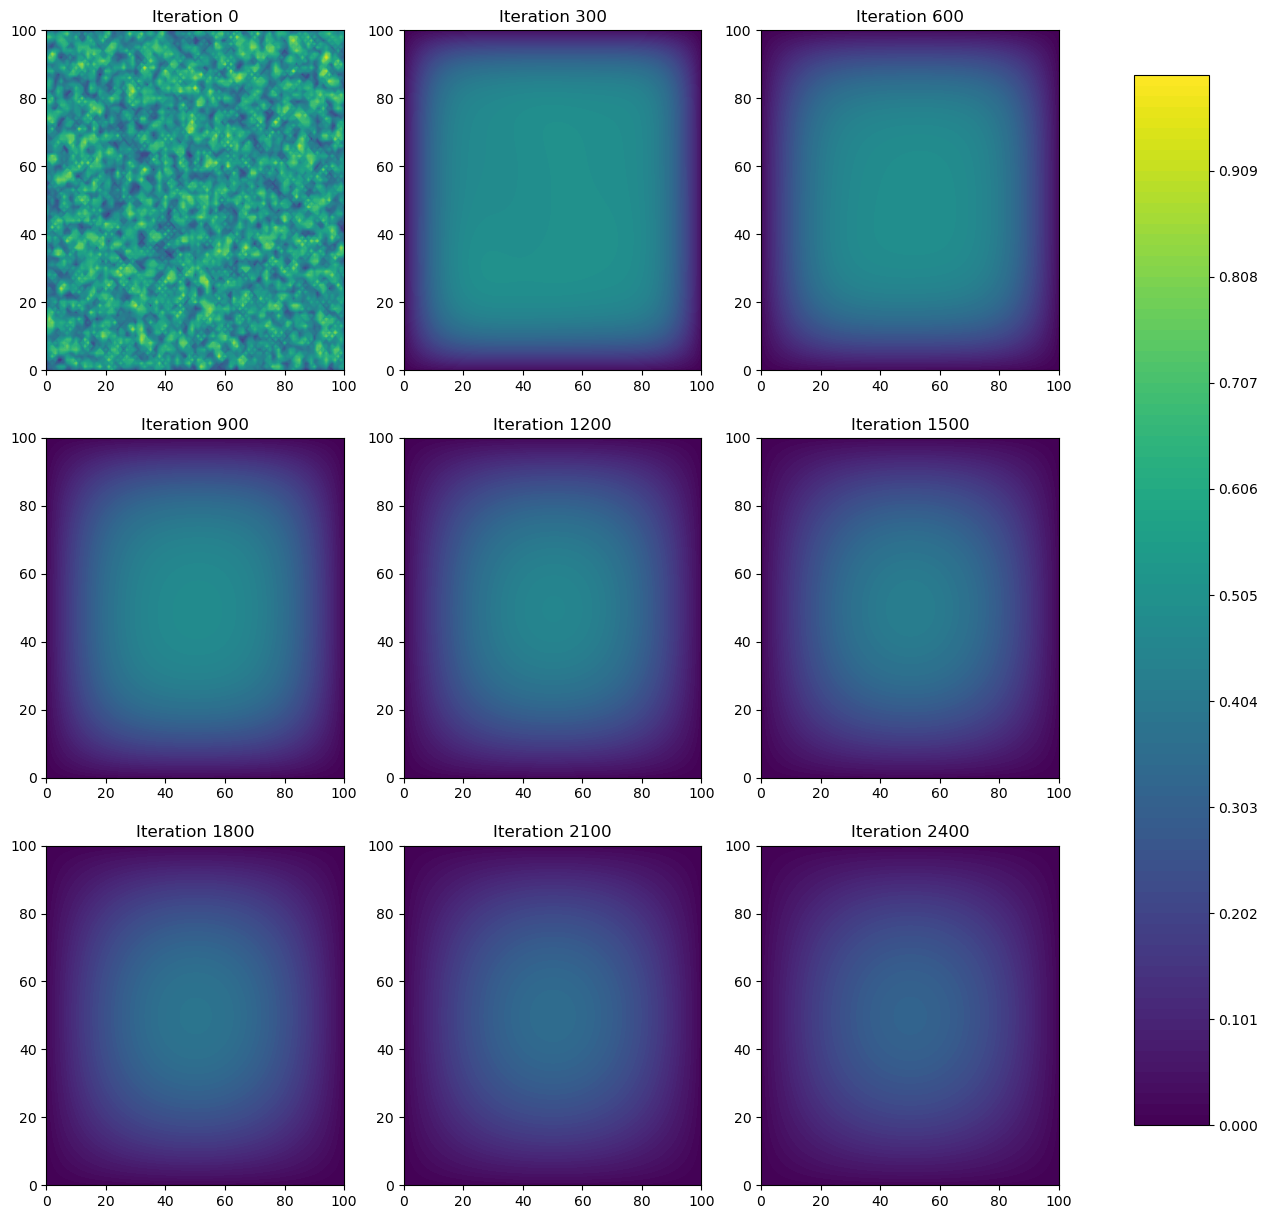

In [8]:
N = 101
epsilon = 0.2
u = np.random.rand(N, N)  # Initial state (random temperature distribution)
A = get_A(N)  # Get the matrix A for our grid size

# Prepare to store intermediate states for visualization
intermediate_states = []
num_iterations = 2700
save_every = 300  # How often to save the state for visualization

start_time = time()
for i in range(num_iterations):
    u = advance_time_matvecmul(A, u, epsilon)
    # Save the state every 300 iterations
    if i % save_every == 0:
        intermediate_states.append(u.copy())
end_time = time()

# total computation time
computation_time = end_time - start_time
print(f"Total computation time for {num_iterations} iterations: {computation_time} seconds")


fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(intermediate_states):
        cax = ax.contourf(intermediate_states[i], levels=np.linspace(0, 1, 100), cmap=cm.viridis)
        ax.set_title(f'Iteration {i * save_every}')
    else:
        ax.axis('off')
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax, cax=cbar_ax)

plt.show()

As we seen from above, the computation time is actually very slow, so we consider using a sparse matrix as well as a jitted version of a function for higher computational efficiency.

### 2. Sparse Matrix in JAX

In [9]:
from jax.experimental import sparse
import jax.numpy as jnp
from jax import grad, jit
from jax.config import config
config.update("jax_enable_x64", True)

/var/folders/11/7r9zjlds5zv03y1vfyk9dx6h0000gn/T/ipykernel_45104/1628035253.py:4: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


#### `get_sparse_A `

In [3]:
from heat_equation import get_sparse_A
print(inspect.getsource(get_sparse_A))

def get_sparse_A(N):
    """
    Generate a sparse matrix representation of the matrix A used for the heat equation.
    Args:
        N (int): The dimension of the grid (N x N).

    Returns:
        A_sp_matrix (BCOO): The sparse matrix representation of A in BCOO format.
    """
    n = N * N
    diagonals = [-4 * jnp.ones(n), jnp.ones(n-1), jnp.ones(n-1), jnp.ones(n-N), jnp.ones(n-N)]
    diagonals = [diagonals[0], diagonals[1].at[(N-1)::N].set(0), diagonals[2].at[(N-1)::N].set(0), diagonals[3], diagonals[4]]
    A = jnp.diag(diagonals[0]) + jnp.diag(diagonals[1], 1) + jnp.diag(diagonals[2], -1) + jnp.diag(diagonals[3], N) + jnp.diag(diagonals[4], -N)
    A_sp_matrix = sparse.BCOO.fromdense(A)
    return A_sp_matrix



Total computation time for 2700 iterations: 1.6103532314300537 seconds


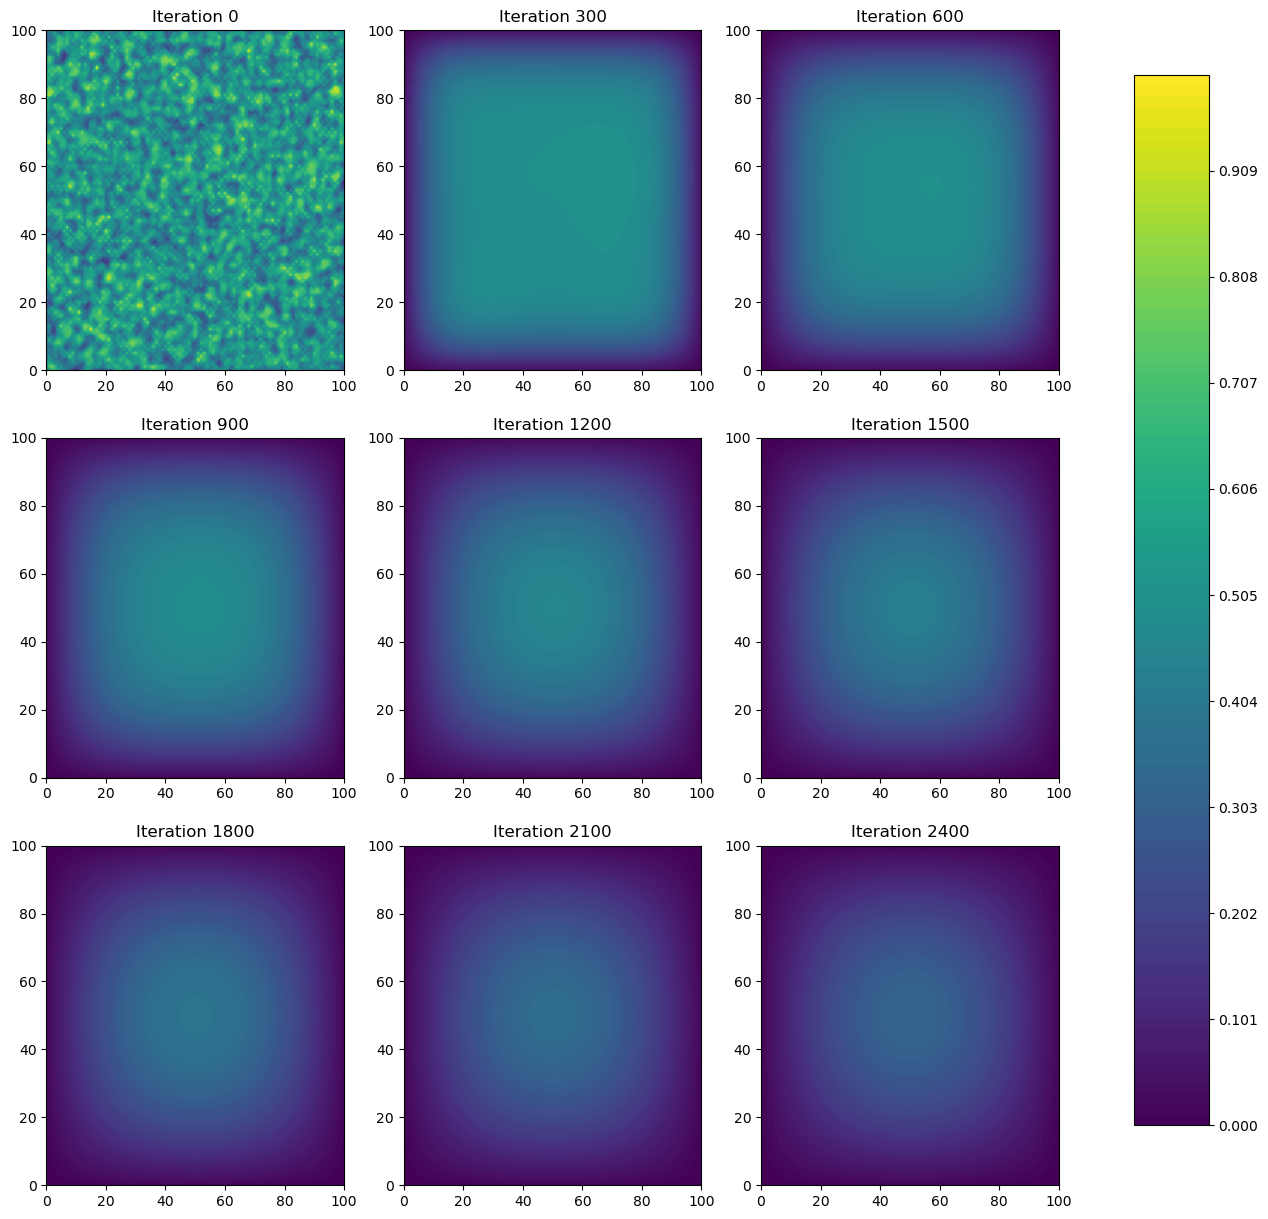

In [11]:
from jax import random, jit

# Initialize
N = 101
epsilon = 0.2
# Generate matrix of shape (N, N) with random values 
key = random.PRNGKey(0)
u = random.uniform(key, (N, N))
A_sp_matrix = get_sparse_A(N)

# jit advance_time_matvecmul
advance_time_matvecmul_jit = jit(advance_time_matvecmul)

# Prepare to store intermediate states for visualization
intermediate_states = []
num_iterations = 2700
save_every = 300  # How often to save the state for visualization

start_time = time()
for i in range(num_iterations):
    u = advance_time_matvecmul_jit(A_sp_matrix, u, epsilon)
    # Save the state every 300 iterations
    if i % save_every == 0:
        intermediate_states.append(u.copy())
end_time = time()

# total computation time
computation_time = end_time - start_time
print(f"Total computation time for {num_iterations} iterations: {computation_time} seconds")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(intermediate_states):
        cax = ax.contourf(intermediate_states[i], levels=np.linspace(0, 1, 100), cmap=cm.viridis)
        ax.set_title(f'Iteration {i * save_every}')
    else:
        ax.axis('off')
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax, cax=cbar_ax)

plt.show()


As we seen from above, it now takes less than a second to run our simulations, which is a huge improvement in computational speed and efficiency. 

### 3. Direct Operation with `numpy`
#### `advance_time_numpy`

In [12]:
from heat_equations import advance_time_numpy
print(inspect.getsource(advance_time_numpy))

def advance_time_numpy(u, epsilon):
    """
    Advances the simulation of the heat equation by one time step using NumPy's vectorized operations.

    Args:
        u (np.ndarray): The current state of the system, an N x N grid.
        epsilon (float): The stability constant.

    Returns:
        np.ndarray: The updated state of the system, an N x N grid.
    """
    N = u.shape[0]
    # pad to (N+2)x(N+2) for border conditions 
    u_padded = np.pad(u, pad_width=1, mode='constant', constant_values=0)

    u_next = u + epsilon * (
        np.roll(u_padded, shift=-1, axis=0)[1:-1, 1:-1] + # Up cuz shift for -1 is backwards and axis=0 gives row
        np.roll(u_padded, shift=1, axis=0)[1:-1, 1:-1] + # Down
        np.roll(u_padded , shift=-1, axis=1)[1:-1, 1:-1] + # Left cuz axix=1 is column
        np.roll(u_padded, shift=1, axis=1)[1:-1, 1:-1] - # Right
        4 * u # Center 
    )

    return u_next



Total computation time for 2700 iterations: 0.5216138362884521 seconds
<class 'list'>


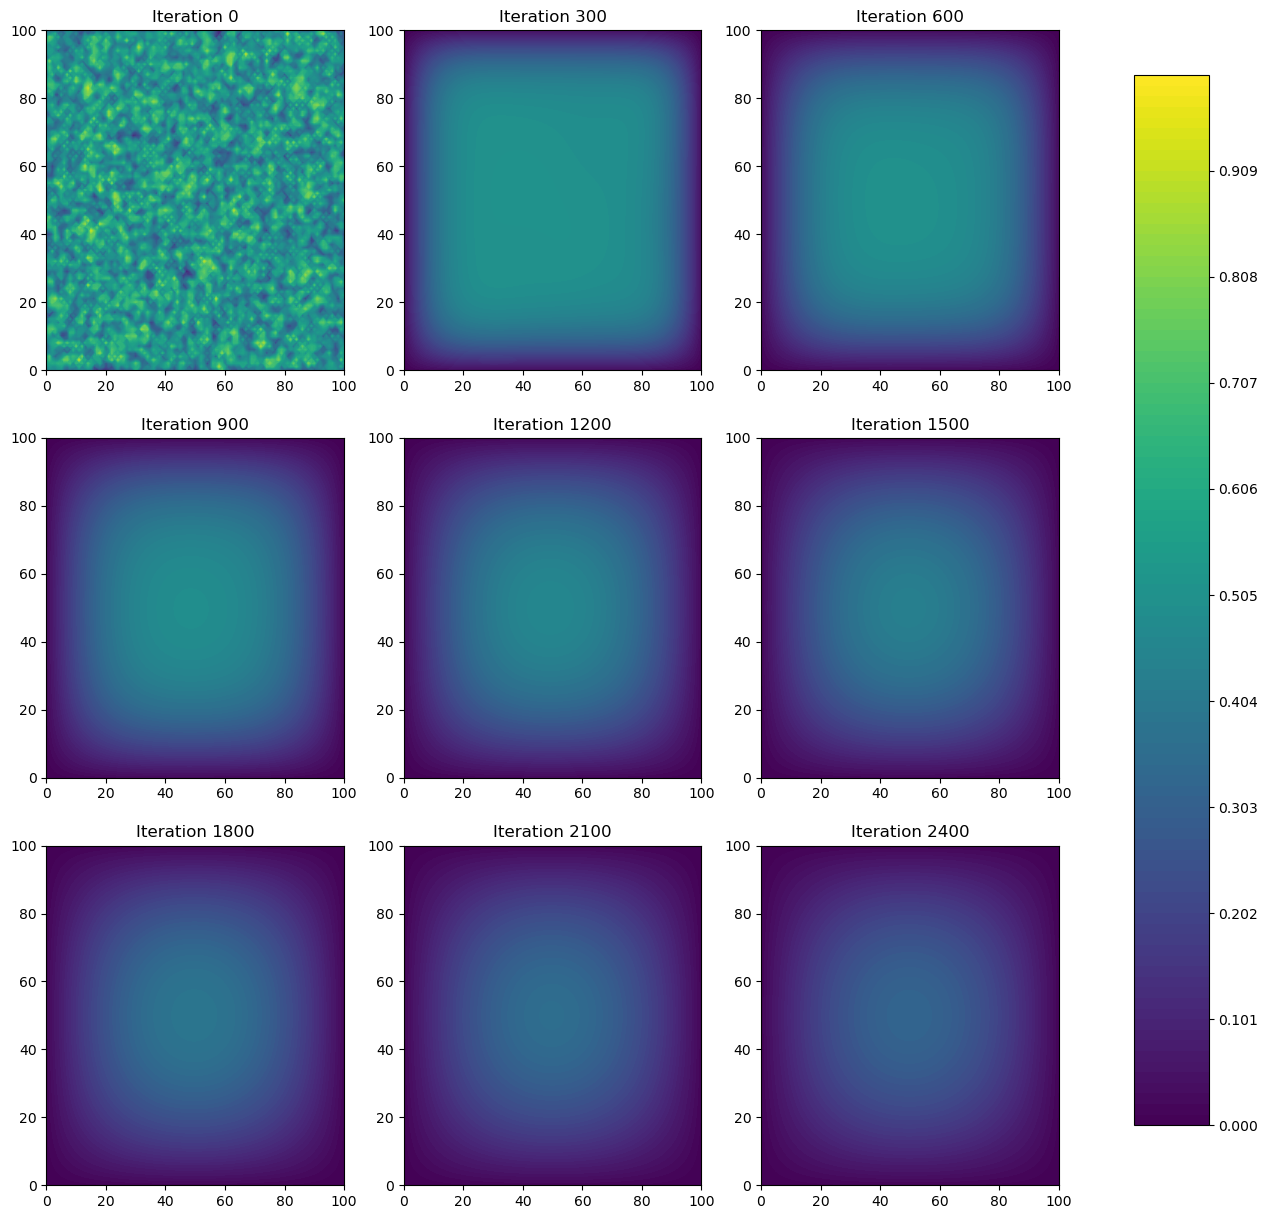

In [13]:
N = 101
epsilon = 0.2
u = np.random.rand(N, N)  # Initial state (random temperature distribution)
# A = get_A(N)  # Get the matrix A for our grid size

# Prepare to store intermediate states for visualization
intermediate_states = []
num_iterations = 2700
save_every = 300  # How often to save the state for visualization

start_time = time()
for i in range(num_iterations):
    u = advance_time_numpy(u, epsilon)
    # Save the state every 300 iterations
    if i % save_every == 0:
        intermediate_states.append(u.copy())
end_time = time()

# total computation time
computation_time = end_time - start_time
print(f"Total computation time for {num_iterations} iterations: {computation_time} seconds")

print(type(intermediate_states))
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(intermediate_states):
        cax = ax.contourf(intermediate_states[i], levels=np.linspace(0, 1, 100), cmap=cm.viridis)
        ax.set_title(f'Iteration {i * save_every}')
    else:
        ax.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax, cax=cbar_ax)

plt.show()

### 3. With `jax`
#### `advance_time_jax`

In [14]:
from heat_equation import advance_time_jax
print(inspect.getsource(advance_time_jax))

@jit
def advance_time_jax(u, epsilon):
    """
    Advances the heat distribution on a grid by one time step using JAX for JIT-compiled execution.

    Args:
        u (jnp.ndarray): The current state of the grid as a 2D JAX array.
        epsilon (float): The diffusion coefficient.

    Returns:
        jnp.ndarray: The updated state of the grid as a 2D JAX array.
    """
    N = u.shape[0]
    u_padded = jnp.pad(u, pad_width=1, mode='constant', constant_values=0)
    u_next = u + epsilon * (
        jnp.roll(u_padded, shift=-1, axis=0)[1:-1, 1:-1] + # Up cuz shift for -1 is backwards and axis=0 gives row
        jnp.roll(u_padded, shift=1, axis=0)[1:-1, 1:-1] + # Down
        jnp.roll(u_padded , shift=-1, axis=1)[1:-1, 1:-1] + # Left cuz axix=1 is column
        jnp.roll(u_padded, shift=1, axis=1)[1:-1, 1:-1] - # Right
        4 * u # Center 
    )

    return u_next



Total computation time for 2700 iterations: 0.23972415924072266 seconds


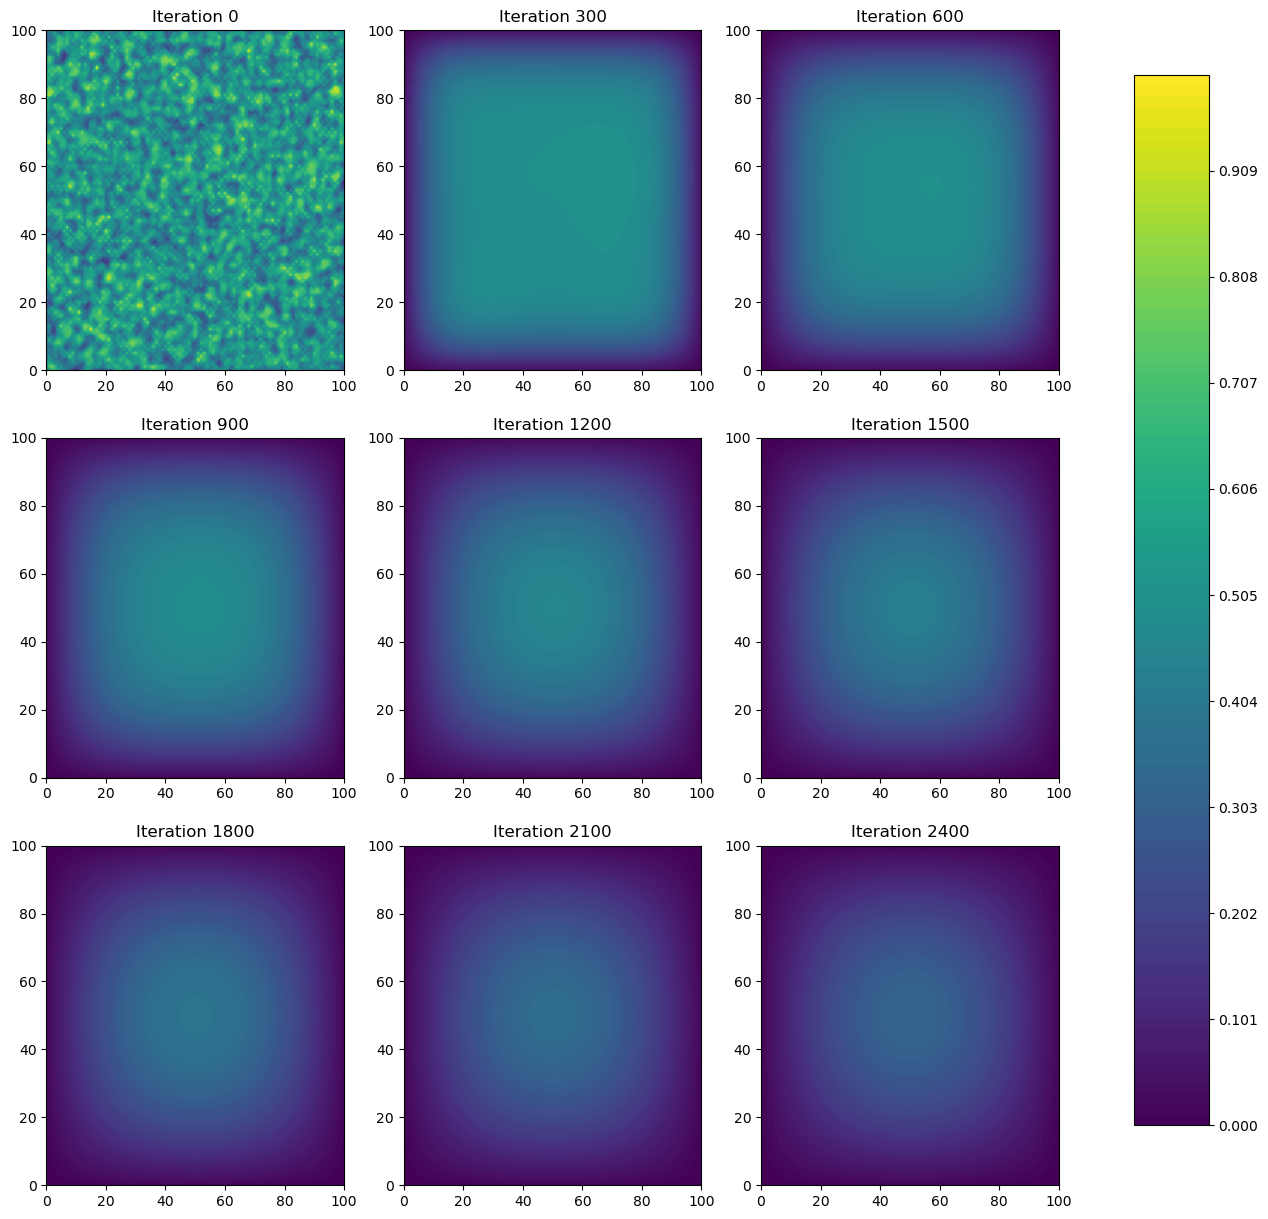

In [15]:
# Initialize
N = 101
epsilon = 0.2
# Generate matrix of shape (N, N) with random values 
key = random.PRNGKey(0)
u = random.uniform(key, (N, N))


# Prepare to store intermediate states for visualization
intermediate_states = []
num_iterations = 2700
save_every = 300  # How often to save the state for visualization

start_time = time()
for i in range(num_iterations):
    u = advance_time_jax(u, epsilon)
    # Save the state every 300 iterations
    if i % save_every == 0:
        intermediate_states.append(u.copy())
end_time = time()

# total computation time
computation_time = end_time - start_time
print(f"Total computation time for {num_iterations} iterations: {computation_time} seconds")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(intermediate_states):
        cax = ax.contourf(intermediate_states[i], levels=np.linspace(0, 1, 100), cmap=cm.viridis)
        ax.set_title(f'Iteration {i * save_every}')
    else:
        ax.axis('off')
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax, cax=cbar_ax)

plt.show()

### 5. Comparison
**With Matrix Multiplication:** 71.08664393424988 seconds \
**With Sparse Matrix Multiplication:** 1.6103532314300537 seconds \
**Direct Operation with `numpy`:** 0.5216138362884521 seconds \
**With `jax`:** 0.23972415924072266 seconds 

As we can see, the first method with matrix multiplication takes a very long time, while the method using direct operation with `jax` is the fastest by a large margin. 

The comparison of the four methods shows a significant difference in performance:

1. **With Matrix Multiplication**: This method is the slowest because full matrix-vector multiplications are computationally expensive and not optimized for sparse matrices.

2. **With Sparse Matrix Multiplication**: Using sparse matrices dramatically improves performance since it takes advantage of the matrix's sparsity. Sparse matrix libraries are optimized to skip calculations for zero elements, which reduces the computational load.

3. **Direct Operation with NumPy**: This method uses NumPy's optimized vectorized operations, which are faster than explicit matrix multiplication, especially for operations that can be expressed as element-wise computations.

4. **With JAX**: This is the fastest method because JAX can further optimize the vectorized operations at the compilation stage, and the compiled code can run on accelerators like GPUs or TPUs.

In terms of ease of writing:

- The **matrix multiplication** method is conceptually straightforward if you are familiar with linear algebra. It directly translates the mathematical expressions into code but can be inefficient in practice.
- The **sparse matrix multiplication** method requires a bit more work to set up since you need to correctly construct the sparse matrix.

However, both of these methods are harder to write because we need to write a separate function (i.e. `get_A` and `get_A_sparse`) to generate the matrix A. 

- The **direct operation with NumPy** method can be easier to write if you are comfortable with NumPy's array operations. It also avoids the complexity of setting up a matrix multiplication.
- The **JAX** method is similar in complexity to the NumPy one, but you need to ensure that the operations are compatible with JAX's requirements (no in-place updates, use of `jnp` instead of `np`, etc.).

Overall, the JAX method offers the best performance due to JIT compilation and potential hardware acceleration. In terms of ease of writing, it is comparable to the direct NumPy method once you are familiar with JAX's constraints and operation.

The best method for a given problem often depends on the specific context and requirements. If execution speed is the highest priority and the code will be run repeatedly, JAX is an excellent choice. If ease of implementation and readability are more critical, and performance is less of an issue, the direct NumPy method might be preferred.